In [1]:
# Load in our libraries
import numpy as np
import pandas as pd
import cv2
import os

from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral,
                                 denoise_wavelet, estimate_sigma, denoise_tv_bregman, denoise_nl_means)
from skimage.filters import gaussian
from skimage.color import rgb2gray
from sklearn.model_selection import train_test_split
from os.path import join as opj
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pylab
plt.rcParams['figure.figsize'] = 10, 10
%matplotlib inline

In [2]:
### Import Keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, Activation
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras import initializers
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.models import load_model

Using TensorFlow backend.


In [3]:
#Load the data
train = pd.read_json("data_train.json")

In [4]:
train.head()

,band_1,band_2,id,inc_angle,is_iceberg
0,"[-27.878360999999998, -27.15416, -28.668615, -...","[-27.154118, -29.537888, -31.0306, -32.190483,...",dfd5f913,43.9239,0
1,"[-12.242375, -14.920304999999999, -14.920363, ...","[-31.506321, -27.984554, -26.645678, -23.76760...",e25388fd,38.1562,0
2,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",58b2aaa0,45.2859,1
3,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",4cfc3a18,43.8306,0
4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",271f93f4,35.6256,0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc796d240f0>]], dtype=object)

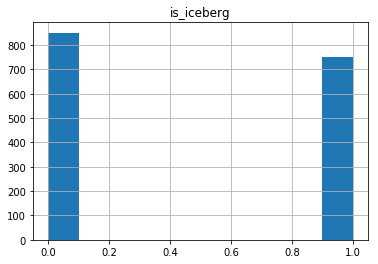

In [5]:
train.hist(column = 'is_iceberg')

### Generate the training data

In [6]:
#Replace empty fields
train.inc_angle.replace(to_replace=dict(na=0), inplace=True)

In [7]:
#Create 3 bands having HH, HV and avg of both
X_band_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_1"]])
X_band_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_2"]])
X_band_3=(X_band_1+X_band_2)/2

In [8]:
#Need to reshape and feature scale the images
X_band_1_norm = (X_band_1 - X_band_1.mean()) / (X_band_1.max() - X_band_1.min())
X_band_2_norm = (X_band_2 - X_band_2.mean()) / (X_band_2.max() - X_band_2.min())
X_band_3_norm = (X_band_3 - X_band_3.mean()) / (X_band_3.max() - X_band_3.min())

In [9]:
def denoise(X, weight, multichannel):
    return np.asarray([denoise_tv_chambolle(item, weight=weight, multichannel=multichannel) for item in X])

def smooth(X, sigma):
    return np.asarray([gaussian(item, sigma=sigma) for item in X])

def grayscale(X):
    return np.asarray([rgb2gray(item) for item in X])

gray_reshape = lambda x: np.asarray([item.reshape(75, 75) for item in x])

to_arr = lambda x: np.asarray([np.asarray(item) for item in x])

tf_reshape = lambda x: np.asarray([item.reshape(75, 75) for item in x])

In [10]:
X_band_1_norm = gray_reshape(to_arr(X_band_1_norm))
X_band_2_norm = gray_reshape(to_arr(X_band_2_norm))
X_band_3_norm = gray_reshape(to_arr(X_band_3_norm))

X_band_1_norm = smooth(denoise(X_band_1_norm, 0.05 , False), 0.5)
X_band_2_norm = smooth(denoise(X_band_2_norm, 0.05 , False), 0.5)
X_band_3_norm = smooth(denoise(X_band_3_norm, 0.05 , False), 0.5)
# print(X_band_3_norm.shape)

X_band_1_norm = tf_reshape(X_band_1_norm)
X_band_2_norm = tf_reshape(X_band_2_norm)
X_band_3_norm = tf_reshape(X_band_3_norm)
# print(X_band_3_norm.shape)

In [11]:
X_train = np.concatenate([X_band_1_norm[:, :, :, np.newaxis], X_band_2_norm[:, :, :, np.newaxis], X_band_3_norm[:, :, :, np.newaxis]], axis=-1)

In [12]:
X_train.shape

(1604, 75, 75, 3)

### Add data to train set

In [13]:
def get_more_images(imgs):
    
    more_images = []
    vert_flip_imgs = []
    hori_flip_imgs = []
      
    for i in range(0,imgs.shape[0]):
        a=imgs[i,:,:,0]
        b=imgs[i,:,:,1]
        c=imgs[i,:,:,2]
        
        av=cv2.flip(a,1)
        ah=cv2.flip(a,0)
        bv=cv2.flip(b,1)
        bh=cv2.flip(b,0)
        cv=cv2.flip(c,1)
        ch=cv2.flip(c,0)
        
        vert_flip_imgs.append(np.dstack((av, bv, cv)))
        hori_flip_imgs.append(np.dstack((ah, bh, ch)))
      
    v = np.array(vert_flip_imgs)
    h = np.array(hori_flip_imgs)
       
    more_images = np.concatenate((imgs,v,h))
    
    return more_images

In [14]:
Xtr_more = get_more_images(X_train)

In [15]:
X_train.size

27067500

In [16]:
Xtr_more.size

81202500

# Data Visualization

In [17]:
X_band_1_norm_v = (X_band_1_norm - X_band_1_norm.min()) 
X_band_2_norm_v = (X_band_2_norm - X_band_2_norm.min()) 
X_band_3_norm_v = (X_band_3_norm - X_band_3_norm.min()) 

In [18]:
X_train_v = np.concatenate([X_band_1_norm[:, :, :, np.newaxis], X_band_2_norm[:, :, :, np.newaxis], X_band_3_norm[:, :, :, np.newaxis]], axis=-1)

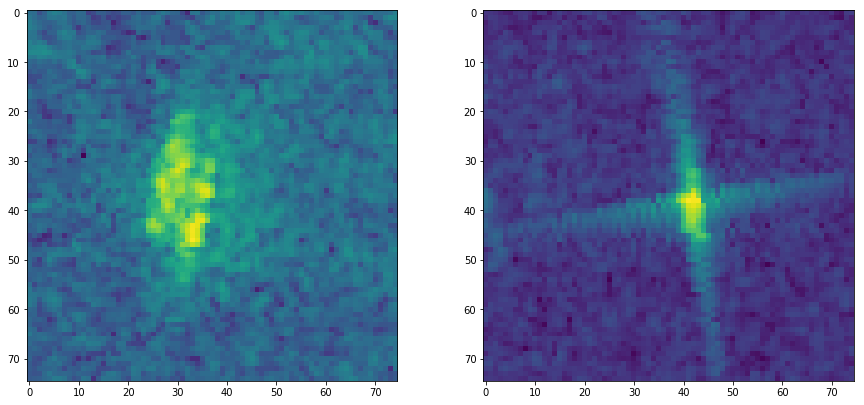

In [19]:
fig = plt.figure(100, figsize=(15,15))
indicies = [12, 8]
band_1_x = train['band_1'].values
subset = np.asarray(band_1_x)[indicies]
subset = np.asarray([np.asarray(item).reshape(75, 75) for item in subset])
for i in range(2):
    ax = fig.add_subplot(2,2,i + 1)
    ax.imshow(subset[i])
plt.show()

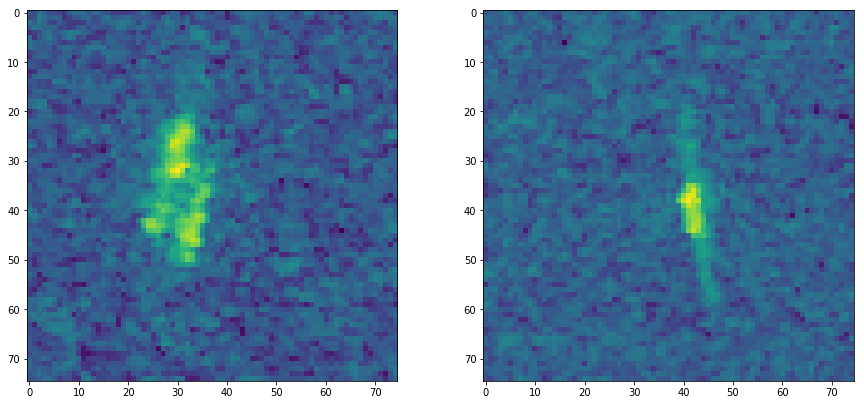

In [20]:
fig = plt.figure(100, figsize=(15,15))
indicies = [12, 8]
band_2_x = train['band_2'].values
subset = np.asarray(band_2_x)[indicies]
subset = np.asarray([np.asarray(item).reshape(75, 75) for item in subset])
for i in range(2):
    ax = fig.add_subplot(2,2,i + 1)
    ax.imshow(subset[i])
plt.show()

In [21]:
#Take a look at a iceberg
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
def plotmy3d(c, name):

    data = [
        go.Surface(
            z=c
        )
    ]
    layout = go.Layout(
        title=name,
        autosize=False,
        width=700,
        height=700,
        margin=dict(
            l=65,
            r=50,
            b=65,
            t=90
        )
    )
    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig)
plotmy3d(X_band_3[12,:,:], 'iceberg')

In [22]:
plotmy3d(X_band_3[8,:,:], 'Ship') #38

## CNN Keras Model

In [23]:
#define our model
def getModel():
    #Building the model
    gmodel=Sequential()
    
    #Conv Layer 1
    gmodel.add(Conv2D(64, kernel_size=(3, 3),activation='relu', input_shape=(75, 75, 3)))
    gmodel.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    gmodel.add(Dropout(0.2))

    #Conv Layer 2
    gmodel.add(Conv2D(128, kernel_size=(3, 3), activation='relu' ))
    gmodel.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    gmodel.add(Dropout(0.2))

    #Conv Layer 3
    gmodel.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    gmodel.add(BatchNormalization(axis = 3))
    gmodel.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    gmodel.add(Dropout(0.2))

    #Conv Layer 4
    gmodel.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    gmodel.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    gmodel.add(Dropout(0.2))

    #Flatten the data for upcoming dense layers
    gmodel.add(Flatten())

    #Dense Layers
    gmodel.add(Dense(512))
    gmodel.add(Activation('relu'))
    gmodel.add(Dropout(0.2))

    #Dense Layer 2
    gmodel.add(Dense(256))
    gmodel.add(Activation('relu'))
    gmodel.add(Dropout(0.2))

    #Sigmoid Layer
    gmodel.add(Dense(1))
    gmodel.add(Activation('sigmoid'))

    mypotim=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    gmodel.compile(loss='binary_crossentropy',
                  optimizer=mypotim,
                  metrics=['accuracy'])
    gmodel.summary()
    return gmodel


def get_callbacks(filepath, patience=2):
    es = EarlyStopping('val_loss', patience=patience, mode="min")
    msave = ModelCheckpoint(filepath, save_best_only=True)
    return [es, msave]

file_path = "model_weights.hdf5"
callbacks = get_callbacks(filepath=file_path, patience=60)

In [24]:
# target_train=np.concatenate((train['is_iceberg'],train['is_iceberg'],train['is_iceberg']))
target_train=train['is_iceberg']
X_train_cv, X_valid, y_train_cv, y_valid = train_test_split(X_train, target_train, random_state=1, train_size=0.8)

/home/kate/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.



In [25]:
gmodel=getModel()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 73, 73, 64)        1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       147584    
__________

In [29]:
history = gmodel.fit(X_train_cv, y_train_cv,
          batch_size=24,
          epochs=50,
          verbose=1,
          validation_data=(X_valid, y_valid),
          callbacks=callbacks)

Train on 1283 samples, validate on 321 samples
Epoch 1/50
1283/1283 [==============================] - 54s - loss: 0.1843 - acc: 0.9143 - val_loss: 0.2710 - val_acc: 0.8847
Epoch 2/50
1283/1283 [==============================] - 51s - loss: 0.2078 - acc: 0.9072 - val_loss: 0.2265 - val_acc: 0.8910
Epoch 3/50
1283/1283 [==============================] - 48s - loss: 0.1964 - acc: 0.9143 - val_loss: 0.2321 - val_acc: 0.8879
Epoch 4/50
1283/1283 [==============================] - 48s - loss: 0.1747 - acc: 0.9166 - val_loss: 0.2592 - val_acc: 0.9003
Epoch 5/50
1283/1283 [==============================] - 49s - loss: 0.1685 - acc: 0.9197 - val_loss: 0.3715 - val_acc: 0.8941
Epoch 6/50
1283/1283 [==============================] - 48s - loss: 0.1596 - acc: 0.9314 - val_loss: 0.2630 - val_acc: 0.8879
Epoch 7/50
1283/1283 [==============================] - 48s - loss: 0.1451 - acc: 0.9400 - val_loss: 0.2262 - val_acc: 0.9097
Epoch 8/50
1283/1283 [==============================] - 48s - loss: 0.1

In [30]:
gmodel.load_weights(filepath=file_path)
score = gmodel.evaluate(X_valid, y_valid, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

320/321 [============================>.] - ETA: 0sTest loss: 0.198956382237
Test accuracy: 0.928348909657


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


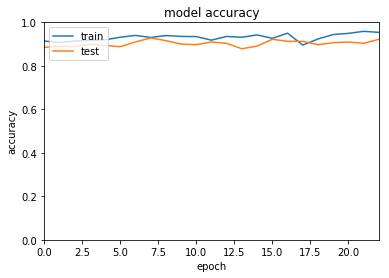

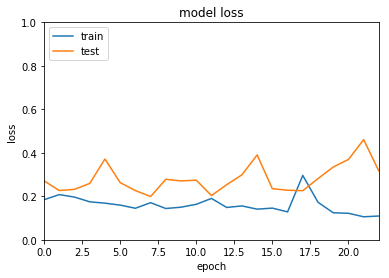

In [31]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.axis((0, 22, 0,1))
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.axis((0, 22, 0,1))
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()